In [665]:
import os
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

%matplotlib widget

# Helper Functions to Parse Files

In [666]:
def load_liveInfo(directory):
    # FileFormat
    #
    # avgParticlesPerCell: 0.145314
    # cutoff: 3.000000
    # domainSizeX: 115.000000
    # domainSizeY: 215.000000
    # domainSizeZ: 145.000000
    # estimatedNumNeighborInteractions: 289010
    # maxParticlesPerCell: 26
    # minParticlesPerCell: 0
    # numCells: 137592
    # numEmptyCells: 131716
    # numHaloParticles: 0
    # numParticles: 19994
    # particleSize: 128
    # particleSizeNeededByFunctor: 72
    # particlesPerBlurredCellStdDev: 0.359923
    # particlesPerCellStdDev: 0.018441
    # rebuildFrequency: 10
    # skin: 1.000000
    # threadCount: 12

    def parseText(text):
        data = {}
        for line in text.split("\n"):
            if len(line) > 0:
                key, value = line.split(":")
                data[key.strip()] = float(value.strip())
        return data

    with open(directory + "/live_info_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data


def load_best_configs(directory):
    # LineFormat
    #
    # Configuration: {Container: $A$ , CellSizeFactor: $B$ , Traversal: $C$ , Load Estimator: $D$ , Data Layout: $E$ , Newton 3: $F$}

    def parseText(text):
        rankings = []
        regex = r"Configuration: {Container: (.*) , CellSizeFactor: (.*) , Traversal: (.*) , Load Estimator: (.*) , Data Layout: (.*) , Newton 3: (.*)}"

        for line in text.split("\n"):
            match = re.search(regex, line)
            if match:
                data = {
                    "Container": match.group(1),
                    "CellSizeFactor": float(match.group(2)),
                    "Traversal": match.group(3),
                    "Load Estimator": match.group(4),
                    "Data Layout": match.group(5),
                    "Newton 3": match.group(6),
                }
                rankings.append(data)

        return rankings

    with open(directory + "/best_configs_0.txt", "r") as file:
        text = file.read()
        data = parseText(text)
        return data

# Load Data from Folders

In [667]:
dataSet = {
    "src_name": [],
    # input
    "avgParticlesPerCell": [],
    "cutoff": [],
    "domainSizeX": [],
    "domainSizeY": [],
    "domainSizeZ": [],
    "estimatedNumNeighborInteractions": [],
    "maxParticlesPerCell": [],
    "minParticlesPerCell": [],
    "numCells": [],
    "numEmptyCells": [],
    "numHaloParticles": [],
    "numParticles": [],
    "particleSize": [],
    "particleSizeNeededByFunctor": [],
    "particlesPerBlurredCellStdDev": [],
    "particlesPerCellStdDev": [],
    "rebuildFrequency": [],
    "skin": [],
    "threadCount": [],
    # output
    "Container": [],
    "CellSizeFactor": [],
    "Traversal": [],
    "Load Estimator": [],
    "Data Layout": [],
    "Newton 3": [],
}

directories = []
for root, dirs, files in os.walk("./data/"):
    for name in dirs:
        directories.append(os.path.join(root, name))


TOP_K_CONFIGS = 3

for directory in directories:
    liveinfo = load_liveInfo(directory)
    best_config = load_best_configs(directory)

    for i, config in enumerate(best_config[:TOP_K_CONFIGS]):
        dataSet["src_name"].append(directory)
        for key in config:
            dataSet[key].append(config[key])

        for key in liveinfo:
            dataSet[key].append(liveinfo[key])

df = pd.DataFrame(dataSet)

# Define Interesting Data to observe

In [668]:
inputs = [
    "avgParticlesPerCell",
    # "cutoff",
    # "domainSizeX",
    # "domainSizeY",
    # "domainSizeZ",
    # "estimatedNumNeighborInteractions",
    "maxParticlesPerCell",
    # "minParticlesPerCell",
    "numCells",
    # "numEmptyCells",
    # "numHaloParticles",
    "numParticles",
    # "particleSize",
    # "particleSizeNeededByFunctor",
    # "particlesPerBlurredCellStdDev",
    "particlesPerCellStdDev",
    # "rebuildFrequency",
    # "skin",
    # "threadCount",
]

outputs = [
    "Container",
    # "CellSizeFactor",
    "Traversal",
    # "Load Estimator",
    "Data Layout",
    "Newton 3",
]

# Filter Data

In [669]:
# Remove any rows where colum lies outside 2 standard deviations
df = df[(np.abs(stats.zscore(df[inputs])) < 2).all(axis=1)]

# Remove any rows where the outcome occures less than 5% of the time
df = df[(df[outputs].apply(lambda x: x.map(
    x.value_counts(normalize=True)) > 0.03).all(axis=1))]

# save to csv
df.to_csv("cleaned.csv", index=False)

X, y = df[inputs], df[outputs]

pd.concat([X, y], axis=1)

avgParticlesPerCell  maxParticlesPerCell  numCells  numParticles  \
0               0.141963                 11.0  137592.0       19533.0   
2               0.141963                 11.0  137592.0       19533.0   
3               1.680961                 13.0   18772.0       31555.0   
4               1.680961                 13.0   18772.0       31555.0   
5               1.680961                 13.0   18772.0       31555.0   
..                   ...                  ...       ...           ...   
227             0.217508                  1.0   42849.0        9320.0   
228             8.163265                 28.0     147.0        1200.0   
231             0.081417                  2.0    4913.0         400.0   
232             0.081417                  2.0    4913.0         400.0   
233             0.081417                  2.0    4913.0         400.0   

     particlesPerCellStdDev           Container              Traversal  \
0                  0.011052    VerletListsCells                vlc_c01   
2                  0.011052         VerletLists      vl_list_iteration   
3                  0.006755    VerletListsCells                vlc_c18   
4                  0.006755    VerletListsCells                vlc_c18   
5                  0.006755    VerletListsCells         vlc_sliced_c02   
..                      ...                 ...                    ...   
227                0.009163  VerletClusterLists       vcl_c01_balanced   
228                0.081258         LinkedCells                 lc_c08   
231                0.050462  VerletClusterLists  vcl_cluster_iteration   
232                0.050462  VerletClusterLists  vcl_cluster_iteration   
233                0.050462  VerletClusterLists                vcl_c06   

    Data Layout  Newton 3  
0           AoS  disabled  
2           AoS  disabled  
3           AoS  disabled  
4           AoS   enabled  
5           AoS   enabled  
..          ...       ...  
227         SoA  disabled  
228         SoA   enabled  
231         SoA  disabled  
232         AoS  disabled  
233         SoA   enabled  

[168 rows x 9 columns]

# Remove Outlies

Text(0.5, 1.0, 'Correlation Matrix')

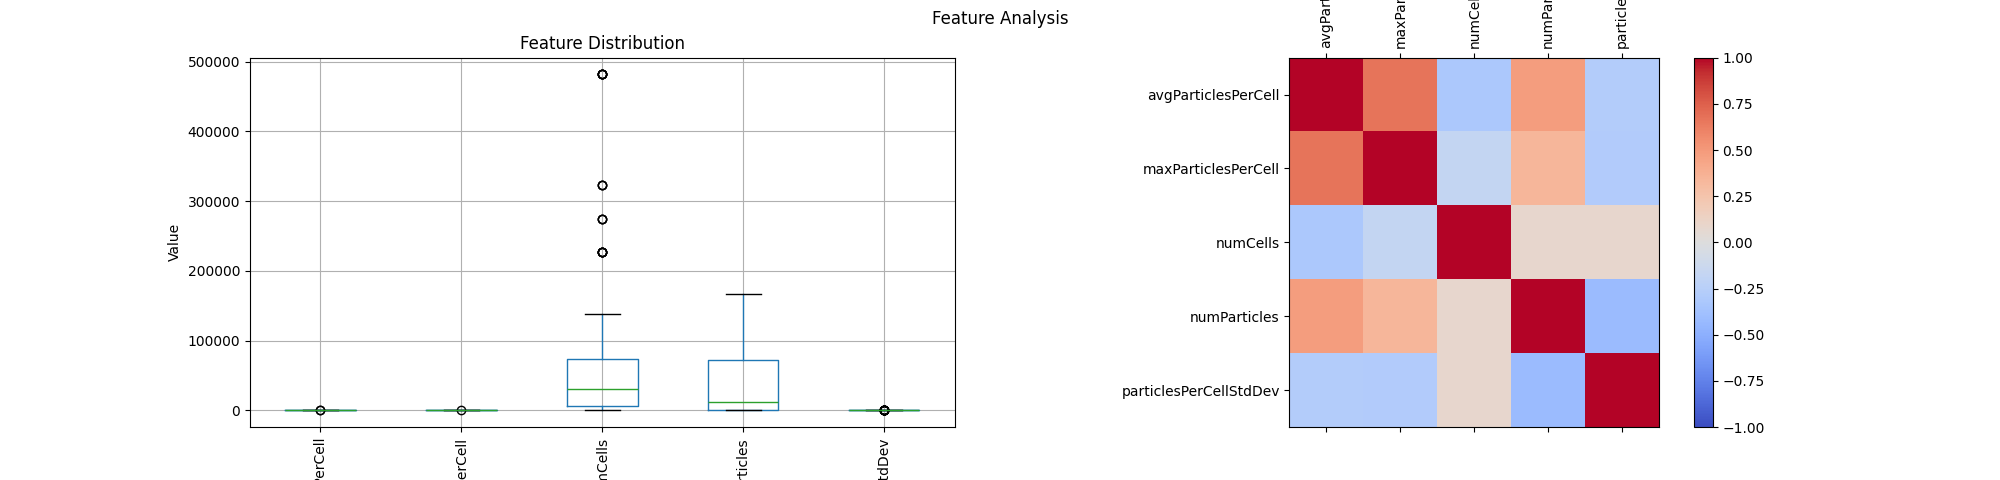

In [670]:
corr = X.corr()

fig, ax = plt.subplots(1, 2)
fig.suptitle("Feature Analysis")
fig.set_figwidth(20)

# Axis 1 Boxplot for each feature

boxplot = X.boxplot(ax=ax[0], showfliers=True)
ax[0].set_title("Feature Distribution")
ax[0].set_ylabel("Value")
ax[0].set_xlabel(f"Feature (n={X.shape[0]})")
ax[0].set_xticklabels(X.columns, rotation=90)

# Correlation Matrix

cax = ax[1].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax[1].set_xticks(range(len(X.columns)))
ax[1].set_yticks(range(len(X.columns)))
ax[1].set_xticklabels(X.columns, rotation=90)
ax[1].set_yticklabels(X.columns)
ax[1].set_title("Correlation Matrix")

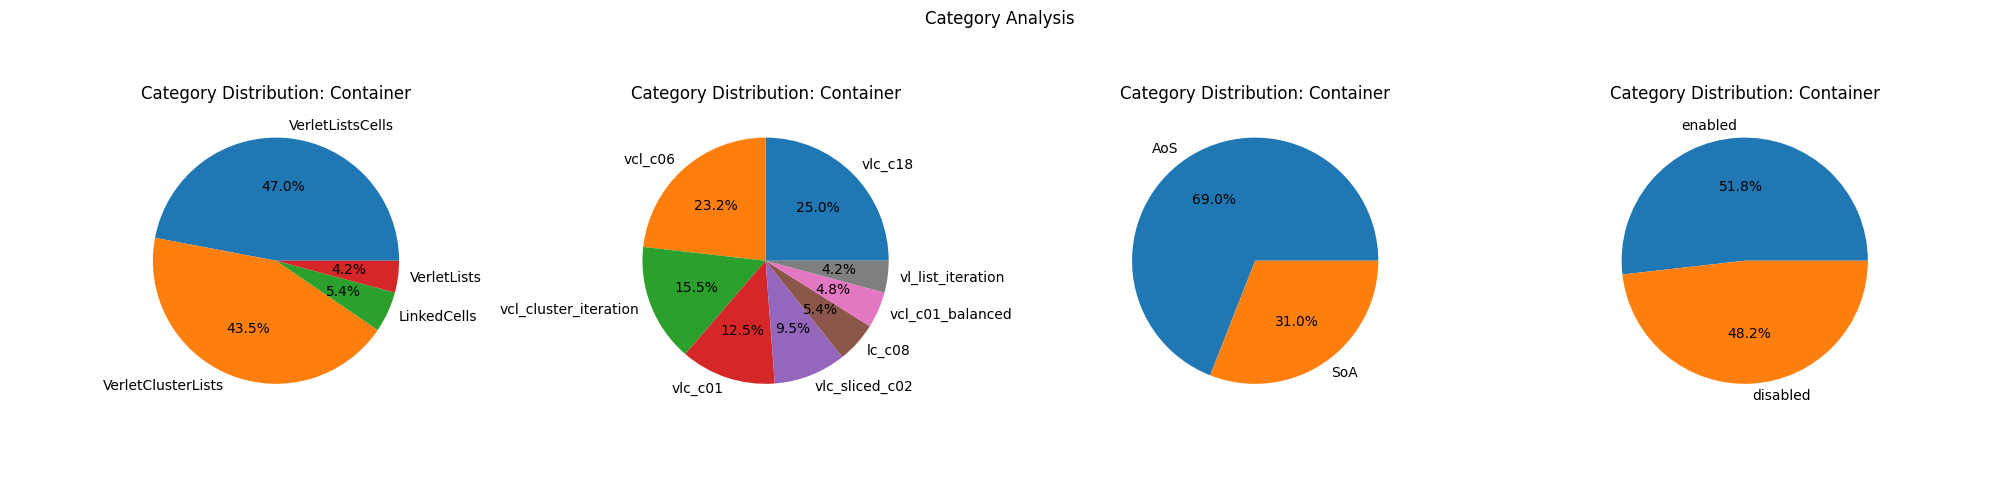

In [671]:
fig, ax = plt.subplots(1, len(y.columns))
fig.suptitle("Category Analysis")
fig.set_figwidth(20)
fig.tight_layout(pad=3.0)
for i, col in enumerate(y.columns):
    y_count = y[col].value_counts()
    ax[i].pie(y_count, labels=y_count.index, autopct='%1.1f%%')
    ax[i].set_title(f"Category Distribution: {y.columns[0]}")

In [672]:
def scatter_2d(df, x_name, y_name, label_name, filter=None):
    fig = plt.figure()
    fig.suptitle(f"2D Scatter Plot: {x_name} vs {y_name} for {label_name}")
    ax = fig.add_subplot(111)

    x = df[x_name]
    y = df[y_name]
    labels = df[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels()]:
        t.set_rotation(45)

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend()


def scatter_3d(df, x_name, y_name, z_name, label_name, filter=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f"3D Scatter Plot: {x_name} vs {y_name} vs {z_name} for {label_name}")

    x = df[x_name]
    y = df[y_name]
    z = df[z_name]
    labels = df[label_name]

    markers = ['o', 'x', 's', 'v', '^']
    for i, c in enumerate(np.unique(labels)):
        if filter is None or c in filter:
            ax.scatter(x[labels == c], y[labels == c], z[labels == c],
                       label=c, marker=markers[i % len(markers)])

    for t in [*ax.get_xticklabels(), *ax.get_yticklabels(), *ax.get_zticklabels()]:
        t.set_rotation(45)

    # format ticklabes
    ax.ticklabel_format(axis='both', style='sci', scilimits=(-4, 2))

    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel(z_name)
    ax.legend()

# Create a bunch of plots to find correlations

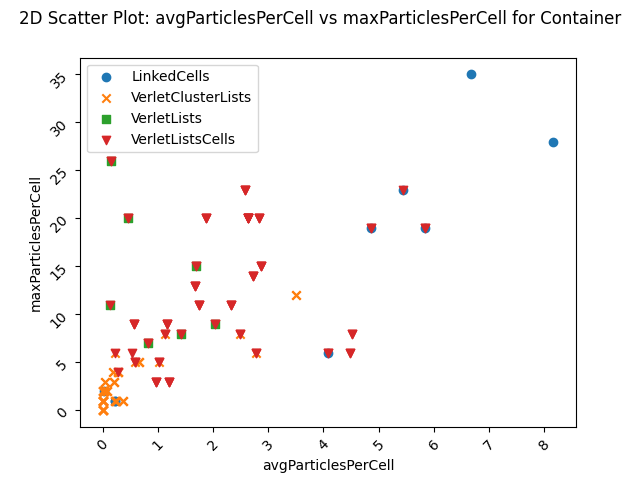

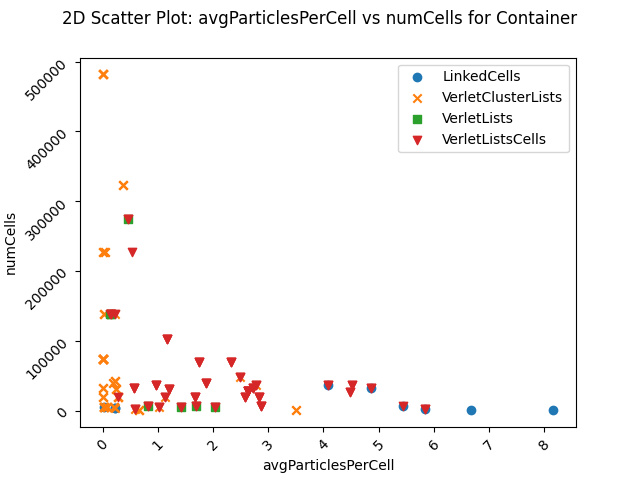

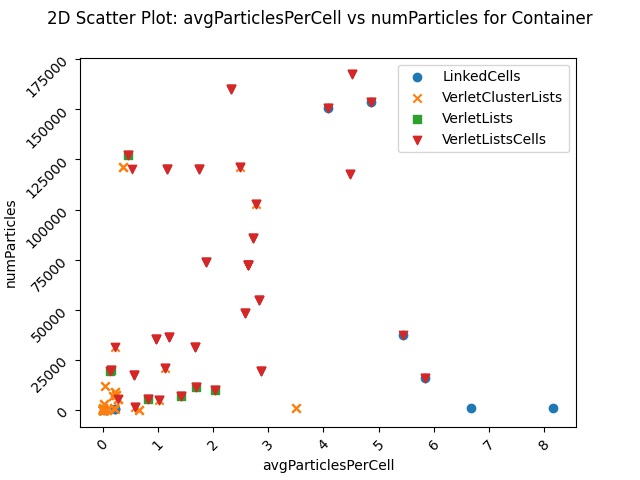

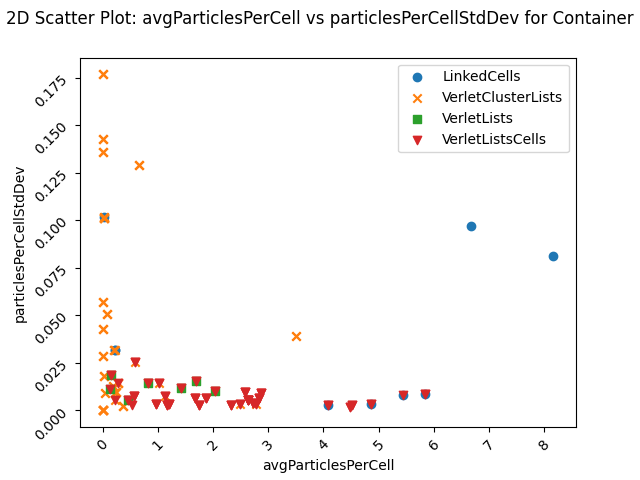

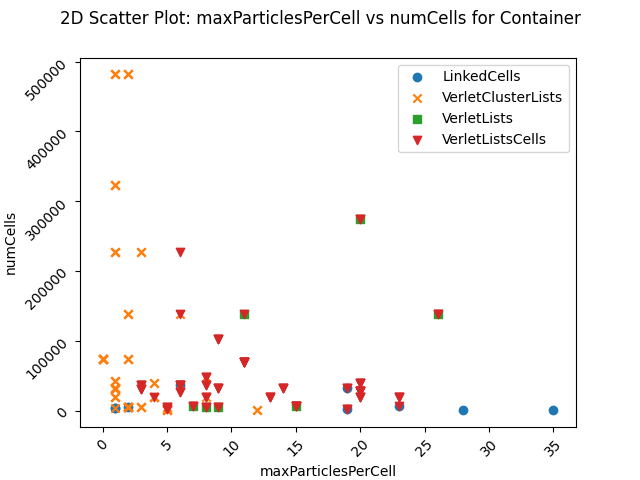

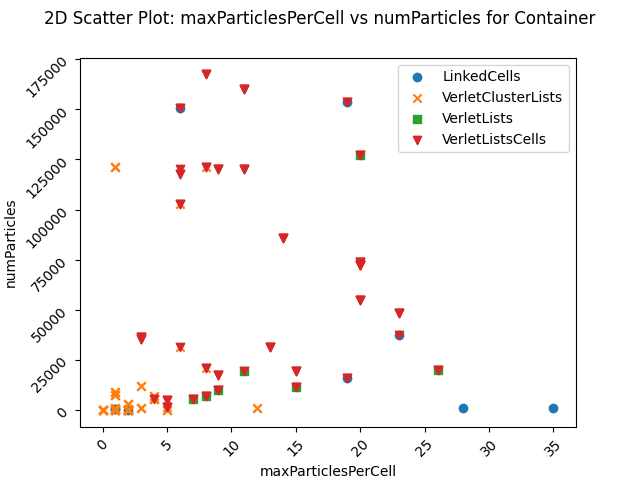

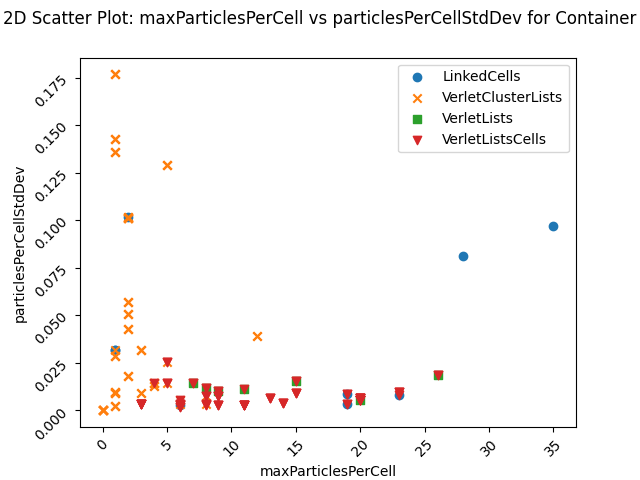

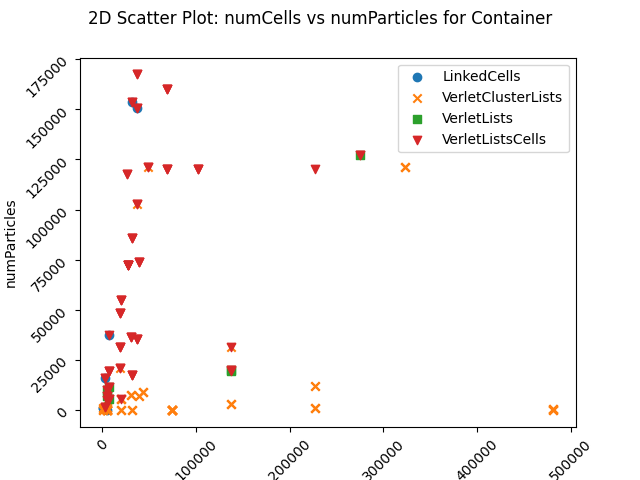

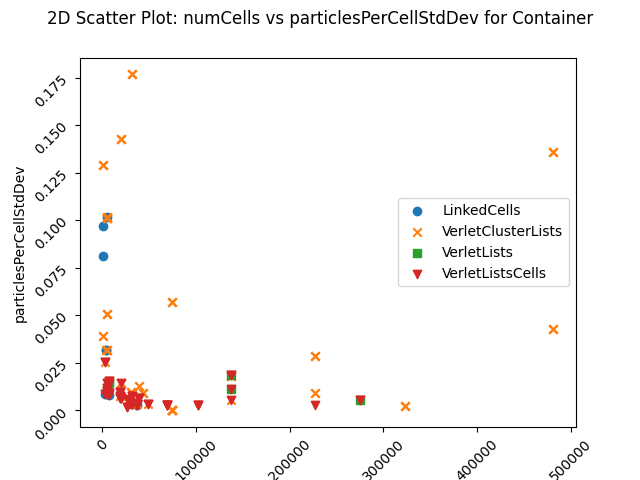

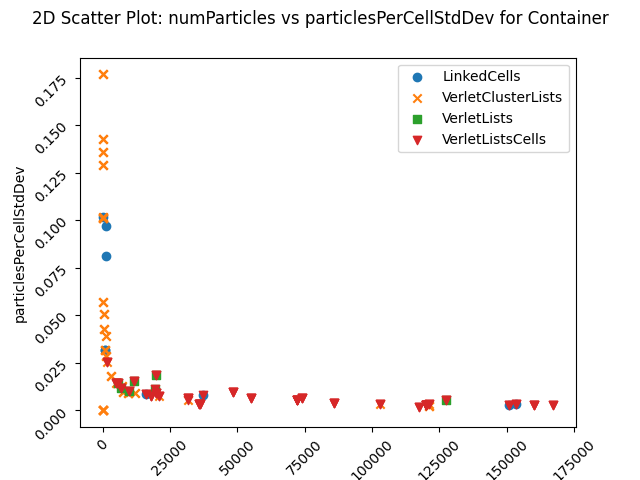

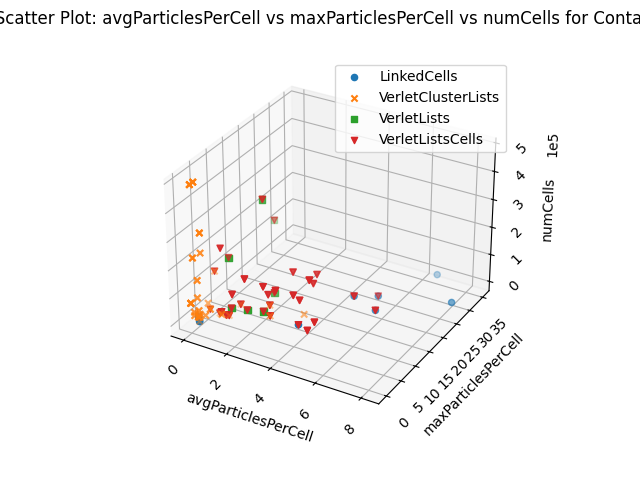

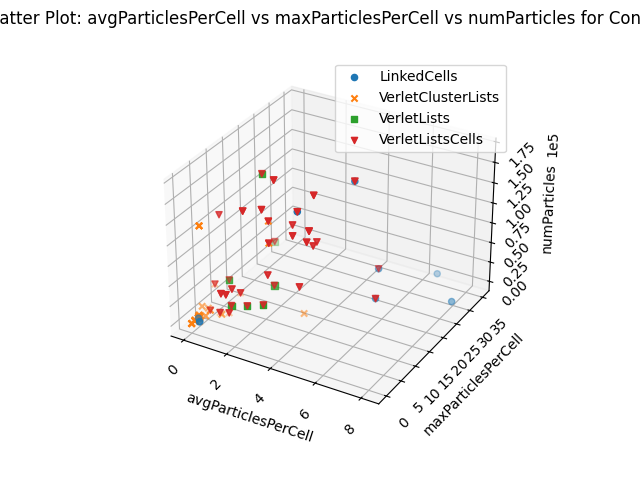

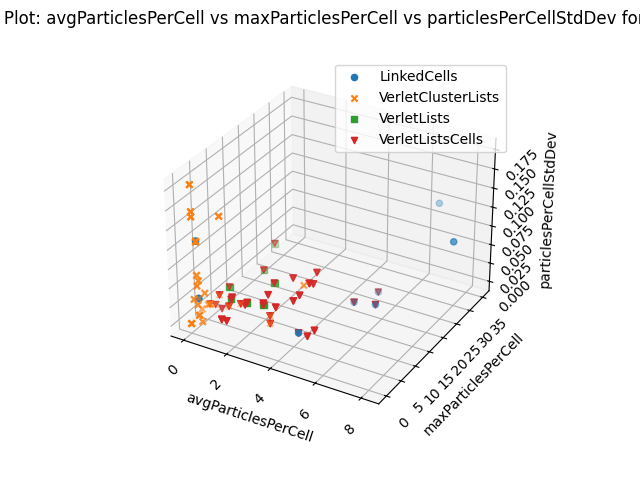

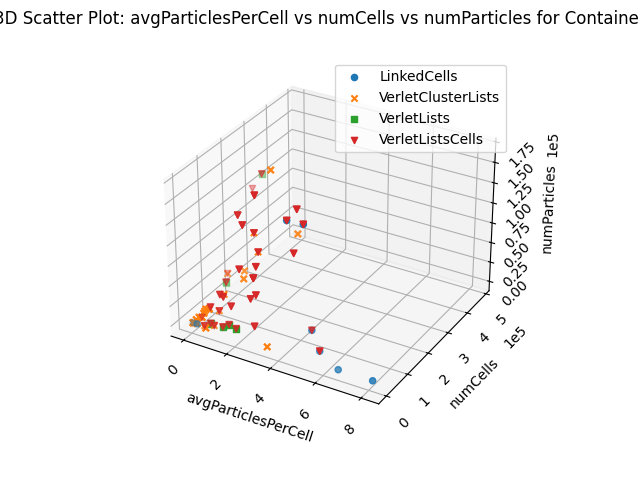

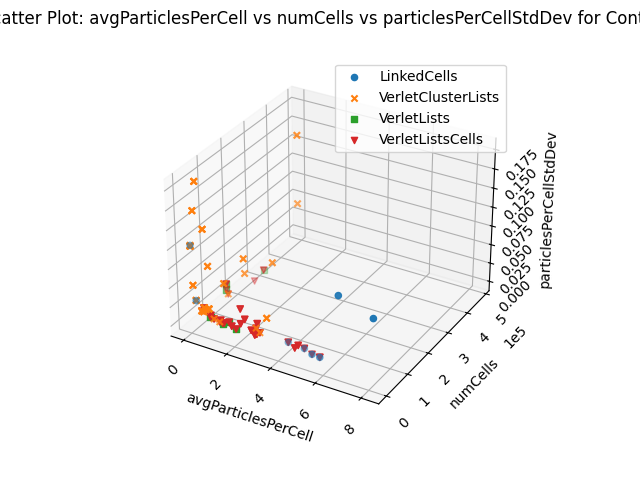

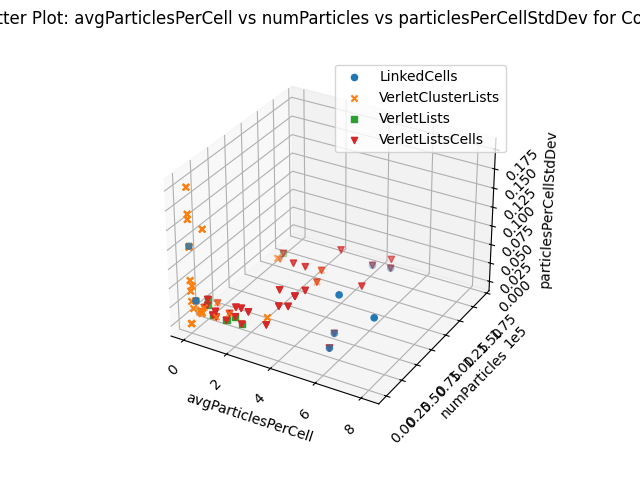

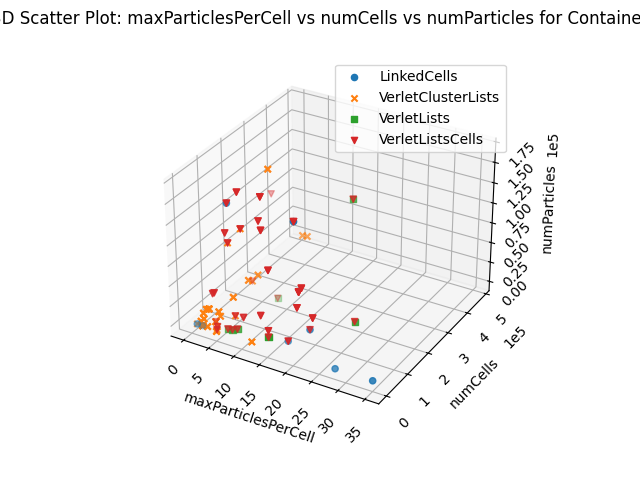

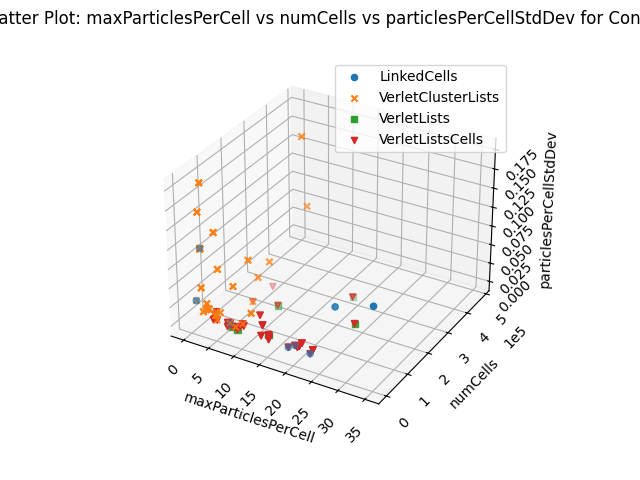

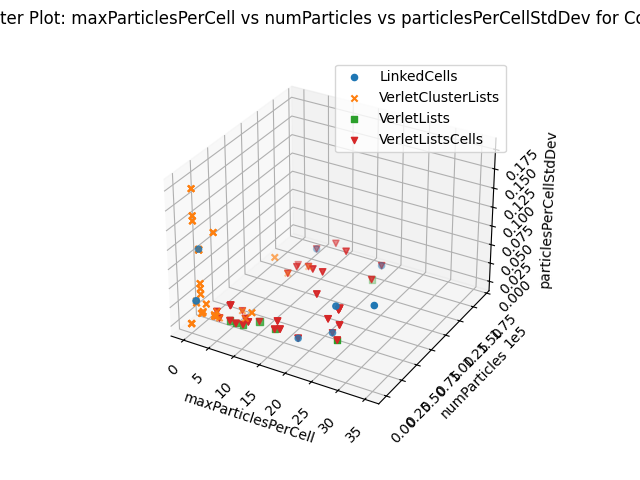

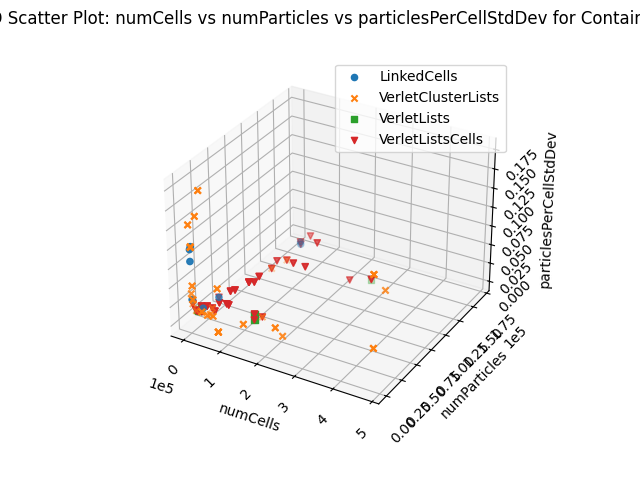

In [673]:
import itertools

label = y.columns[0]

for x in itertools.combinations(X.columns, 2):
    scatter_2d(df, x[0], x[1], label)

for x in itertools.combinations(X.columns, 3):
    scatter_3d(df, x[0], x[1], x[2], label)

# Determine Some Rules

In [674]:
obersvationsContainer = []
obersvationsTraversal = []
obersvationsDataLayout = []
obersvationsNewton3 = []

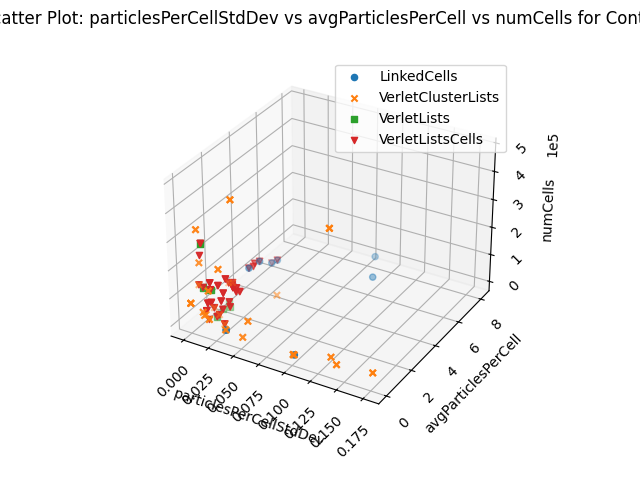

In [675]:
scatter_3d(df, "particlesPerCellStdDev", "avgParticlesPerCell", "numCells",
           "Container")

In [676]:
obersvationsContainer.append('if "particlesPerCellStdDev" is in [0.0, 0.2] and "numEmptyCells" is low([0,40000]) and "avgParticlesPerCell" is low([0,1]) then "Container" is VerletClusterLists')
obersvationsContainer.append('if "averageParticlesPerCell" is high([5, inf]) then "Container" is LinkedCell')

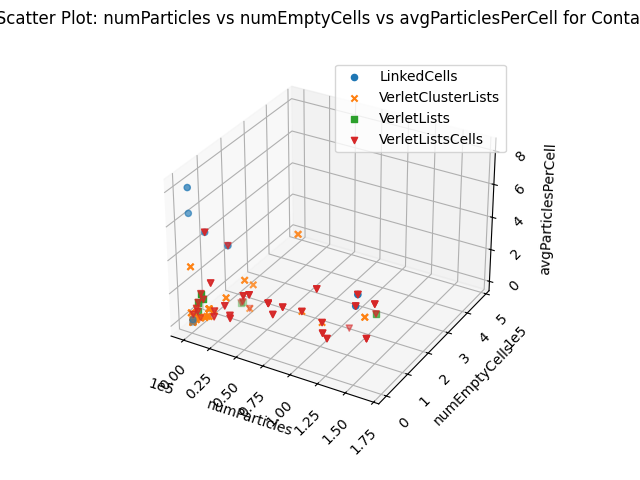

In [677]:
scatter_3d(df, "numParticles", "numEmptyCells", "avgParticlesPerCell",
           "Container")

In [678]:
obersvationsContainer.append('If "numParticles" is in [0.0, 175000] and "numCells" is low([0,10^5]) and "avgParticlesPerCell" is low([0,5]) then "Container" is VerleListCells')
obersvationsContainer.append('If "numParticles" is in [0.0, 50000] and "numCells" is low([0,10^5]) and "avgParticlesPerCell" is med([3,8]) then "Container" is LinkedCells')

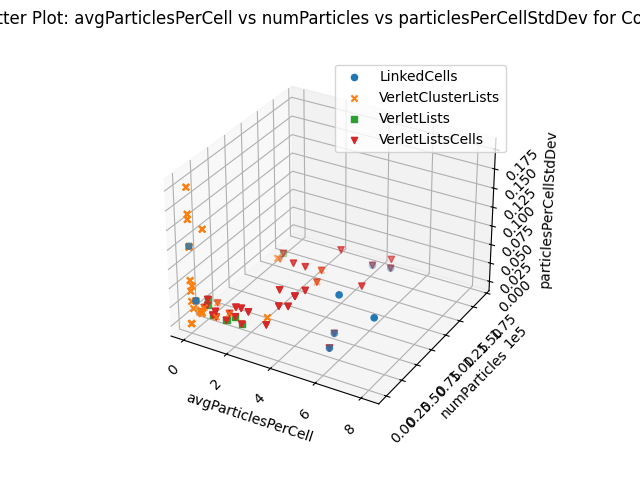

In [679]:
scatter_3d(df, "avgParticlesPerCell",
           "numParticles",  "particlesPerCellStdDev", "Container")

In [680]:
obersvationsContainer.append('If "avgParticlesPerCell" is in [0, inf] and "numParticles" is low([0,50000]) and "particlesPerCellStdDev" is low([0,0.1]) then "Container" is LinkedCell')
obersvationsContainer.append('If "avgParticlesPerCell" is in [1, 5] and "numParticles" is low([75000,200000]) and "particlesPerCellStdDev" is low([0,0.05]) then "Container" is VerletListCells')
obersvationsContainer.append('If "avgParticlesPerCell" is in [0, 0.5] then "Container" is VerletClusterLists')

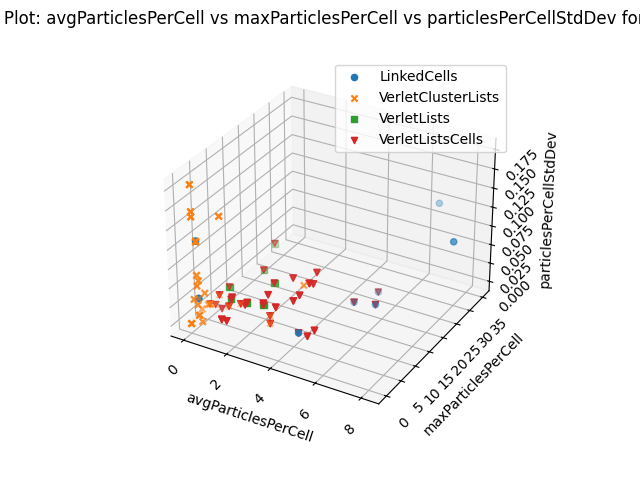

In [681]:
scatter_3d(df, "avgParticlesPerCell",
           "maxParticlesPerCell",  "particlesPerCellStdDev", "Container")

In [682]:
obersvationsContainer.append('If "avgParticlesPerCell" is in [0, 1] and "maxParticlesPerCell" is low([0,5]) and "particlesPerCellStdDev" is low([0,0.2]) then "Container" is VerletClusterLists')

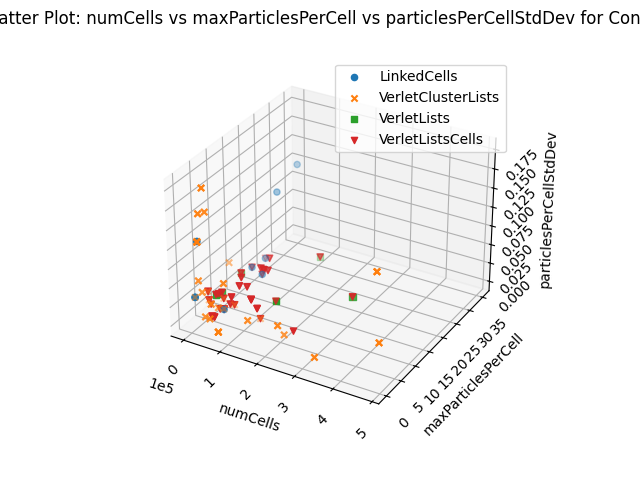

In [683]:
scatter_3d(df, "numCells",
           "maxParticlesPerCell",  "particlesPerCellStdDev", "Container")

In [684]:
obersvationsContainer.append('If "numCells" is in large[2*10^6, inf] then "Container" is VerletClusterLists')

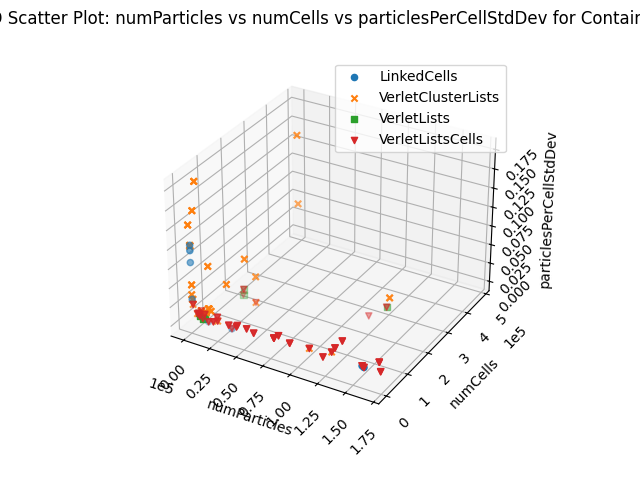

In [685]:
scatter_3d(df, "numParticles", "numCells", "particlesPerCellStdDev",
           "Container")

In [686]:
obersvationsContainer.append('If "numParticles" is in [250000, inf] and "numCells" is in [0, 10^5] and "particlesPerCellStdDev" is in [0, 0.05] then "Container" is VerletListCells')

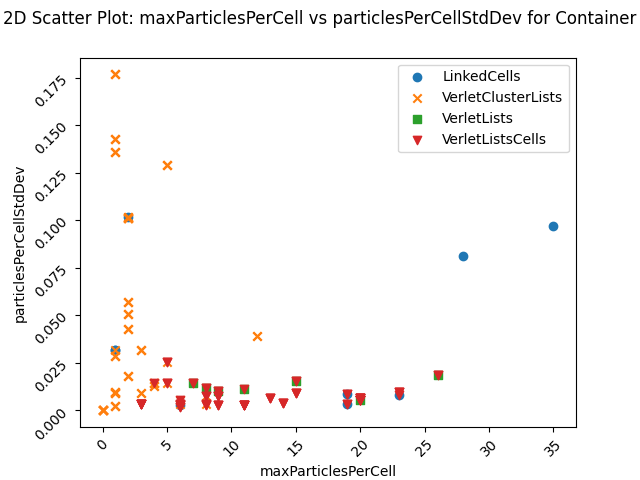

In [687]:
scatter_2d(df, "maxParticlesPerCell", "particlesPerCellStdDev", "Container")

In [688]:
obersvationsContainer.append('If "maxParticlesPerCell" is in [0, 5] and "particlesPerCellStdDev" is in [0, 0.2] then "Container" is VerletClusterLists')
obersvationsContainer.append('If "maxParticlesPerCell" is in [5, 25] and "particlesPerCellStdDev" is in [0, 0.25] then "Container" is VerletListsCells')

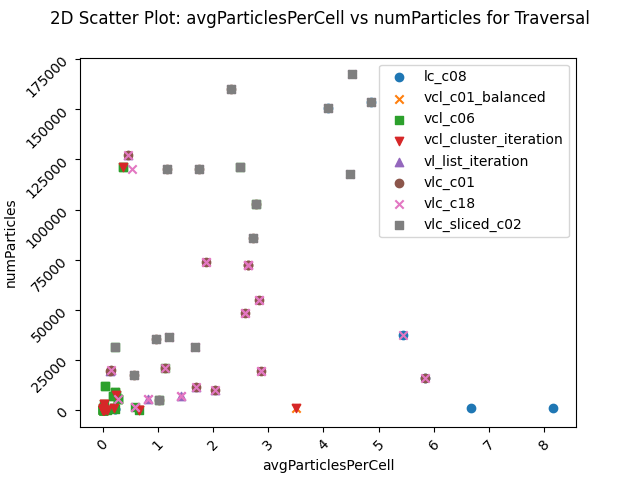

In [689]:
scatter_2d(df, "avgParticlesPerCell", "numParticles", "Traversal")

In [690]:
obersvationsTraversal.append('If "avgParticlesPerCell" is in [1, 5] and "numParticles" is in [100000, 200000] then "Traversal" is vlc_sliced_c02')
obersvationsTraversal.append('If "avgParticlesPerCell" is in [0, 0.2] and "numParticles" is in [0, 40000] then "Traversal" is vcl_cluster_iteration')
obersvationsTraversal.append('If "avgParticlesPerCell" is in [0.05, 0.35] and "numParticles" is in [0, 15000] then "Traversal" is vcl_c06')

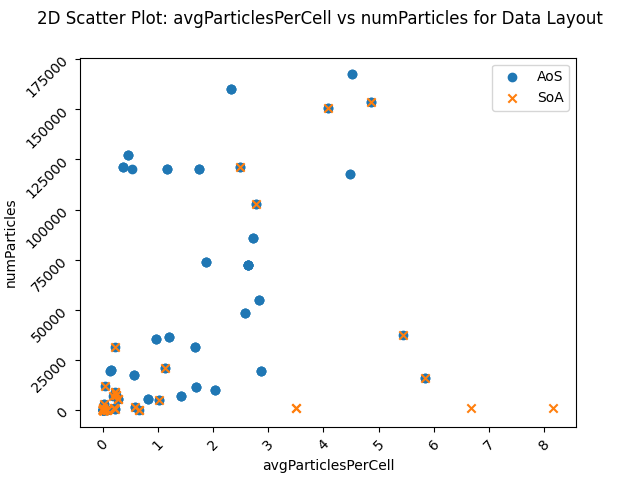

In [691]:
scatter_2d(df, "avgParticlesPerCell", "numParticles", "Data Layout")

In [692]:
obersvationsDataLayout.append(
    'If "avgParticlesPerCell" is in [0, 0.5] and "numParticles" is in [0, 20000] then "Data Layout" is SoA')
obersvationsDataLayout.append(
    'If "not("avgParticlesPerCell" is in [0, 0.5] and "numParticles" is in [0, 20000]) then "Data Layout" is AoS')

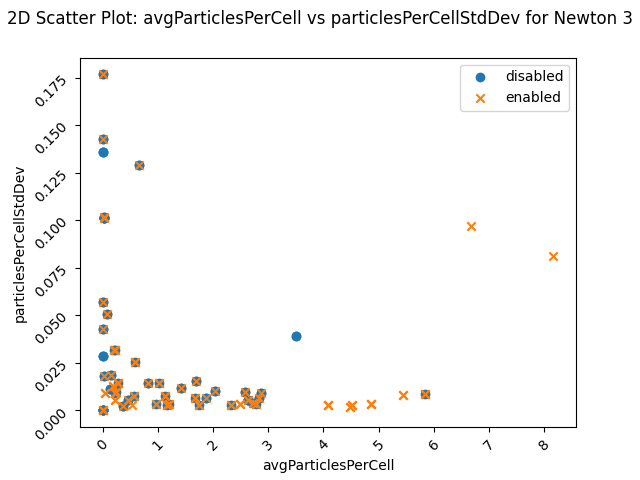

In [693]:
scatter_2d(df, "avgParticlesPerCell", "particlesPerCellStdDev", "Newton 3")

In [694]:
obersvationsNewton3.append(
    'If "avgParticlesPerCell" is in [0, 0.3] then "Newton 3" is disabled')
obersvationsNewton3.append(
    'If "particlesPerCellStdDev" is in [0, 0.025] then "Newton 3" is enabled')

In [695]:
print("\nObersvations for Container")
for rule in obersvationsContainer:
    print("\t" + rule)

print("\nObersvations for Traversal")
for rule in obersvationsTraversal:
    print("\t" + rule)

print("\nObersvations for Data Layout")
for rule in obersvationsDataLayout:
    print("\t" + rule)

print("\nObersvations for Newton 3")
for rule in obersvationsNewton3:
    print("\t" + rule)


Obersvations for Container
	if "particlesPerCellStdDev" is in [0.0, 0.2] and "numEmptyCells" is low([0,40000]) and "avgParticlesPerCell" is low([0,1]) then "Container" is VerletClusterLists
	if "averageParticlesPerCell" is high([5, inf]) then "Container" is LinkedCell
	If "numParticles" is in [0.0, 175000] and "numCells" is low([0,10^5]) and "avgParticlesPerCell" is low([0,5]) then "Container" is VerleListCells
	If "numParticles" is in [0.0, 50000] and "numCells" is low([0,10^5]) and "avgParticlesPerCell" is med([3,8]) then "Container" is LinkedCells
	If "avgParticlesPerCell" is in [0, inf] and "numParticles" is low([0,50000]) and "particlesPerCellStdDev" is low([0,0.1]) then "Container" is LinkedCell
	If "avgParticlesPerCell" is in [1, 5] and "numParticles" is low([75000,200000]) and "particlesPerCellStdDev" is low([0,0.05]) then "Container" is VerletListCells
	If "avgParticlesPerCell" is in [0, 0.5] then "Container" is VerletClusterLists
	If "avgParticlesPerCell" is in [0, 1] and "m